In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_AC_preLL_57to62keV/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_DC_preLL_57to62keV/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE_path = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

sim_dCCE = np.loadtxt(sim_dCCE_path, delimiter=',').T
depth_grid = sim_dCCE[0]

### In these, b=electron trapping, c=hole trapping
def e_cce(b, c):
    ### electron-dominated signal
    return (1.-b*sim_dCCE[1][::-1])*(1.-c*sim_dCCE[2][::-1])
def h_cce(b, c):
    ### hole-dominated signal
    return (1.-b*sim_dCCE[3][::-1])*(1.-c*sim_dCCE[4][::-1])

etrap_map = np.zeros((37,37))
htrap_map = np.zeros((37,37))
with open('/home/cosilab/COSITrapping/UCSDdet_trappingprodmap.txt', 'r') as file:
    for line in file:
        splitline = line.split(' ')
        p = int(splitline[1])
        n = int(splitline[3])
        etrap_map[p,n] = float(splitline[4])
        htrap_map[p,n] = float(splitline[5])
# print(etrap_map)

/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
file_dict = {'Cs137': [['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat'], \
                       ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']], \
            'Ba133': [['20231005_Ba133_AC_600V.dat'], ['20231006_Ba133_DC_600V.dat']], \
            'Na22': [['20231024_Na22_AC_600V_1.dat', '20231024_Na22_AC_600V_2.dat', '20231026_Na22_AC_600V.dat'], \
                     ['20231024_Na22_DC_600V.dat', '20231025_Na22_DC_600V_1.dat', '20231025_Na22_DC_600V_2.dat', '20231026_Na22_DC_600V.dat']], \
            'Am241': [['20230920_Am241_AC_600V.dat', '20231026_Am241_AC_600V.dat'], \
                      ['20230922_Am241_DC_600V_1.dat', '20230922_Am241_DC_600V_2.dat']]}

erange_dict = {'Cs137': [630., 667.], 'Ba133': [330., 360.], 'Na22': [1220., 1280.], 'Am241': [50., 64.]}
zbin_dict = {'Cs137': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Ba133': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Na22': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Am241': np.linspace(calibrator.zmin, calibrator.zmax, 31)}

# Loop and make depth-calibrated dataframes

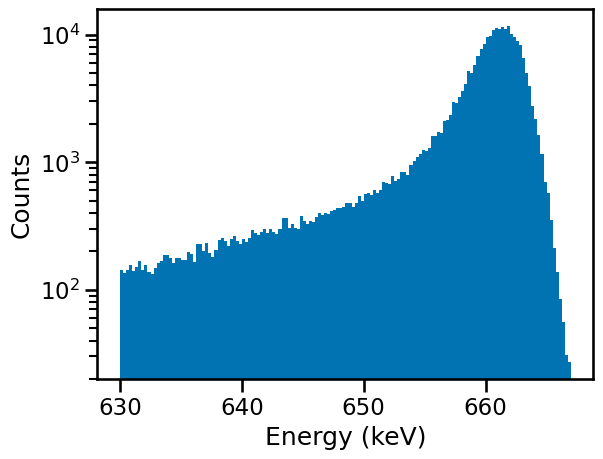

FWHM = 4.09
FWTM = 9.98


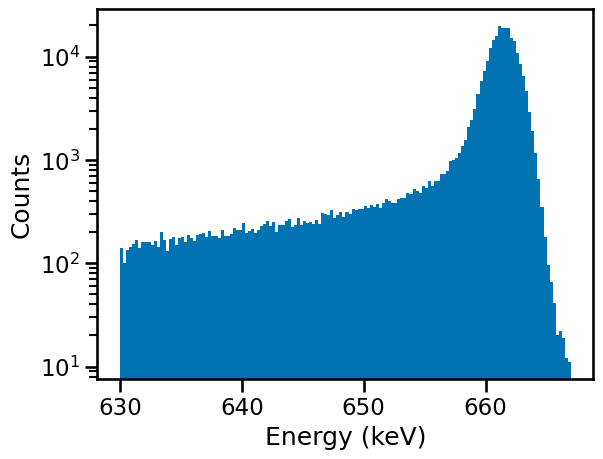

FWHM = 2.53
FWTM = 5.29


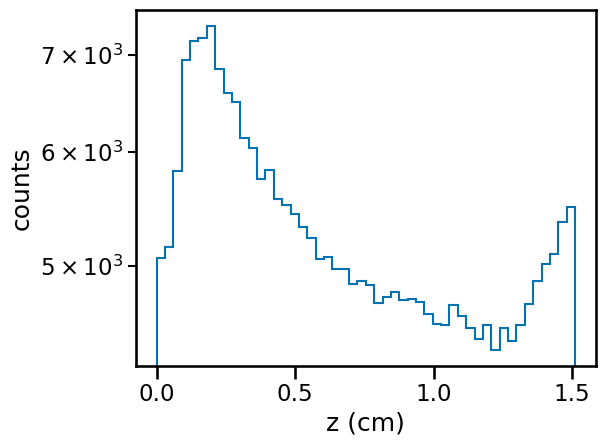

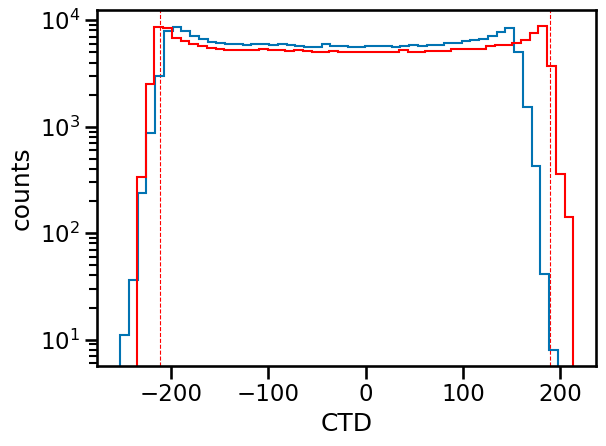

In [6]:
data_dict = {}
# for source in file_dict:
for source in ['Cs137']:
    emin = erange_dict[source][0]
    emax = erange_dict[source][1]
    
    string = source + 'allACDC_preLL'
    
    ## Read in the dat files
    fullpaths = []
    for p in np.concatenate(file_dict[source]):
        fullpaths.append(datpath + 'preLL/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)
    bins = int((emax-emin) * 4)

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'bad'] =  bad
            ctd_obs_map[p][n] = ctd_obs[~bad]
            ctd_stretch_map[p][n] = ctd_stretch[~bad]
            ctd_obs_flat.append(ctd_obs[~bad])
            ctd_stretch_flat.append(ctd_stretch[~bad])

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    data_dict[source] = df
    
    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'][~df['bad'].values], bins=bins, range=(emin, emax))
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'][~df['bad'].values], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.show()
    # plt.savefig(plot_dir + 'depth_' + string + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.show()
    # plt.savefig(plot_dir + "CTD_" + string + ".pdf")

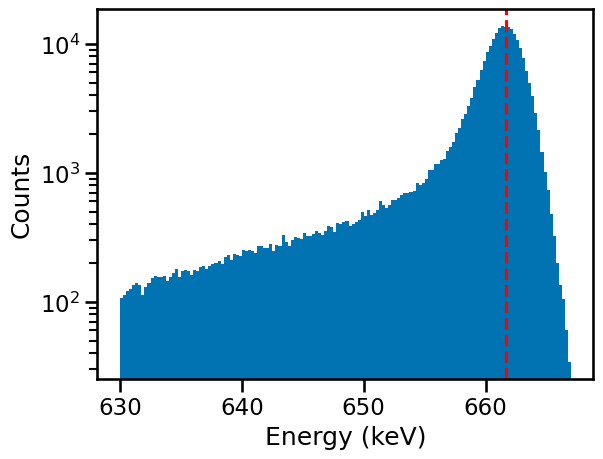

/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 3.5
FWTM = 7.94


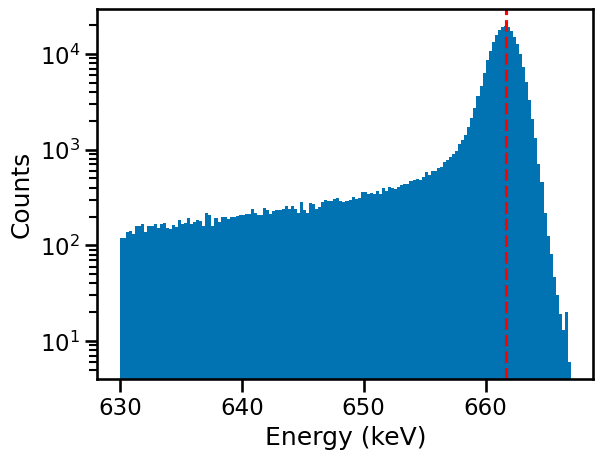

FWHM = 2.64
FWTM = 5.15


In [7]:
# for source in file_dict:
for source in ['Cs137']:
    
    emin = erange_dict[source][0]
    emax = erange_dict[source][1]

    string = source + 'allACDC_preLL'
    
    df = data_dict[source]
    
    for p in range(37):
        for n in range(37):
            En_z = UnivariateSpline(depth_grid, 1.000689*h_cce(etrap_map[p,n], 0.540))
            Ep_z = UnivariateSpline(depth_grid, 1.001133*e_cce(etrap_map[p,n], 0.540))

            depth = df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z']
            energy_p = df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p']
            energy_n = df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_n']
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'depth_corrected_energy_p'] =  energy_p/Ep_z(depth)
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'depth_corrected_energy_n'] =  energy_n/En_z(depth)

    bins = int((emax-emin) * 4)
    plt.figure()
    hist,binedges,_  = plt.hist(df['depth_corrected_energy_p'][~df['bad'].values], bins=bins, range=(emin, emax))
    plt.axvline(source_dict[source], color='red', ls='dashed')
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['depth_corrected_energy_n'][~df['bad'].values], bins=binedges)
    plt.axvline(source_dict[source], color='red', ls='dashed')
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))
